In [274]:
import pandas as pd
import glob
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
warnings.filterwarnings("ignore", category=FutureWarning)

files = glob.glob('./server_results/grid_search/*.csv')


In [275]:
# not used
def plot_grouped_bar_grouped(df, x, hue, group, y, datasetname):
    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(12, 6))

    # Combine hue and group into a single categorical column for better grouping
    df['combined_hue'] = df[hue].astype(str) + " | " + df[group].astype(str)

    # Plot the boxplot
    sns.boxplot(
        data=df,
        x=x,
        hue='combined_hue',  # Use the combined hue
        y=y,
        ax=ax,
        palette=sns.color_palette("Set2"),  # Use a better palette
    )

    # Set labels and title
    ax.set_xlabel(x.replace('_',' ').title(), fontsize=12)
    ax.set_ylabel(y.upper(), fontsize=12)
    ax.set_title(f'{y} Distribution for {x}, {hue}, and {group} in {datasetname}', fontsize=14)

    # Customize ticks
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    # Place legend at the bottom, without border
    ax.legend(
        title=f'{hue} | {group}',
        fontsize=12,
        title_fontsize=12,
        loc='lower center',
        bbox_to_anchor=(0.5, 1.05),  # Position legend outside plot
        ncol=3,  # Arrange legend in a single row
        frameon=False  # Remove legend border
    )

    # Adjust layout to ensure everything fits
    plt.tight_layout()
    plt.show()

In [276]:
def handle_matcher_names(df):
    substitutions = {
        'header_values_default': 'H+V def.',
        'header_values_simple': 'H+V simp.',
        'header_values_verbose': 'H+V ver.',
        'header_values_repeat': 'H+V rep.',
        'header_values_prefix': 'H+V pref.',
        'header_only': 'V only',
        'header_values_verbose_notype': 'H+V ver. notyp',
        'header_values_columnvaluepair_notype': 'H+V col-val notyp',
        'header_header_values_repeat_notype': 'H+V rep. notyp',
        'header_values_default_notype': 'H+V def. notyp',
    }

    # Replace encoding_mode values using the substitutions dictionary
    df['encoding_mode'] = df['encoding_mode'].replace(substitutions)

    # Capitalize 'sampling_mode' values
    df['sampling_mode'] = df['sampling_mode'].str.title()

    return df


    

def best_aggregate(df):

    df_grouped = df.groupby(['encoding_mode', 'sampling_mode', 'sampling_size'])[
        'mrr'].agg(['mean', 'median', 'min', 'max', 'std']).reset_index()

    df_grouped = df_grouped.sort_values(by='mean', ascending=False)

    print(df_grouped.head(10).to_string())
    return df_grouped


def most_high_mrr(df):
    df['method_strategy'] = df['encoding_mode'] + '_' + \
        df['sampling_mode'] + '_' + df['sampling_size'].astype(str)
    highest_mrr_counts = df.groupby('method_strategy')['mrr'].apply(
        lambda x: (x == x.max()).sum()).reset_index(name='count')
    print(highest_mrr_counts.head(10).to_string())
    return df


def plot_grouped_bar(df, x, hue, group, y, datasetname, figsize=(15, 5)):
    # Create the figure and axes
    fig, ax = plt.subplots(figsize=figsize)

    print(datasetname)

    # df = df[df['sampling_mode'] == 'mixed']

    if group == 'sampling_size':
        df = df[df['sampling_size'] == 10]

    order = df.groupby(x)[y].mean().sort_values(ascending=False).index

    hue_order = df.groupby(hue)[y].mean().sort_values(ascending=False).index
    

    # Plot the boxplot
    sns.boxplot(
        data=df,
        x=x,
        hue=hue,
        y=y,
        ax=ax,
        palette=sns.color_palette("Set2"),  # Use a better palette
        order=order,
        hue_order=hue_order
        , showfliers=False

    )

    # Set labels and title
    ax.set_xlabel(x.replace('_',' ').title(), fontsize=12)
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
    ax.set_ylabel(y.upper(), fontsize=12)
    # ax.set_title(f'{y} Distribution for {x} and {hue} in {datasetname}', fontsize=14)#

    # Customize ticks
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    # Place legend at the bottom, without border
    ax.legend(
        title=hue.replace('_',' ').title(),
        fontsize=12,
        title_fontsize=12,
        loc='lower center',
        bbox_to_anchor=(0.5, 0.98),  # Position legend outside plot
        ncol=len(df[hue].unique()),  # Arrange legend in a single row
        frameon=False  # Remove legend border
    )

    # Remove the top and right spines
    sns.despine()

    # Save the figure as a high-resolution PDF
    fig.savefig("figures/grid_search_retriever_encmodes.pdf", format='pdf', dpi=300)

    # Adjust layout to ensure everything fits
    plt.tight_layout()
    plt.show()




In [277]:

all_dfs_list=[]
datasetnames =[]
for file in files:
    datasetname = file.split('_')[0]
    datasetname = file.split('/')[-1].split('_')[0]    
    datasetnames.append(datasetname)
    df = pd.read_csv(file)
    handle_matcher_names(df)
    all_dfs_list.append(df)

    if datasetname=='GDC':
        gdc_df = df

all_dfs = pd.concat(all_dfs_list)

    

In [278]:
gdc_df_filtered = gdc_df[gdc_df['target_table'] == 'Huang.csv']
gdc_df_filtered = gdc_df_filtered.sort_values(by='mrr', ascending=False)


columns_to_select = [
     'ncols_tgt', 'nrows_src', 'nrows_tgt', 'nmatches',
    'encoding_mode', 'sampling_mode', 'sampling_size', 'runtime', 'mrr', 
    'All_RecallAtSizeofGroundTruth'
]

gdc_df_filtered_selected = gdc_df_filtered[columns_to_select]
print(gdc_df_filtered_selected.head(20))


     ncols_tgt  nrows_src  nrows_tgt  nmatches encoding_mode sampling_mode  \
96         736        110       4478        19      H+V rep.        Random   
132        736        110       4478        19     H+V simp.        Random   
136        736        110       4478        19     H+V simp.      Frequent   
104        736        110       4478        19      H+V rep.         Mixed   
105        736        110       4478        19      H+V rep.         Mixed   
101        736        110       4478        19      H+V rep.      Frequent   
100        736        110       4478        19      H+V rep.      Frequent   
141        736        110       4478        19     H+V simp.         Mixed   
137        736        110       4478        19     H+V simp.      Frequent   
133        736        110       4478        19     H+V simp.        Random   
102        736        110       4478        19      H+V rep.      Frequent   
117        736        110       4478        19      H+V ver.    

In [279]:
# for df in all_dfs_list:
#     best_aggregate(df)

In [280]:
# best_aggregate(all_dfs)

In [281]:
# for i,df in enumerate(all_dfs_list):
#     plot_grouped_bar(df, 'encoding_mode', 'sampling_mode',
#                      'sampling_size', 'mrr', datasetnames[i])

In [282]:

# plot_grouped_bar(all_dfs, 'encoding_mode', 'sampling_mode', 'sampling_size', 'mrr','All datasets')

ChemBL


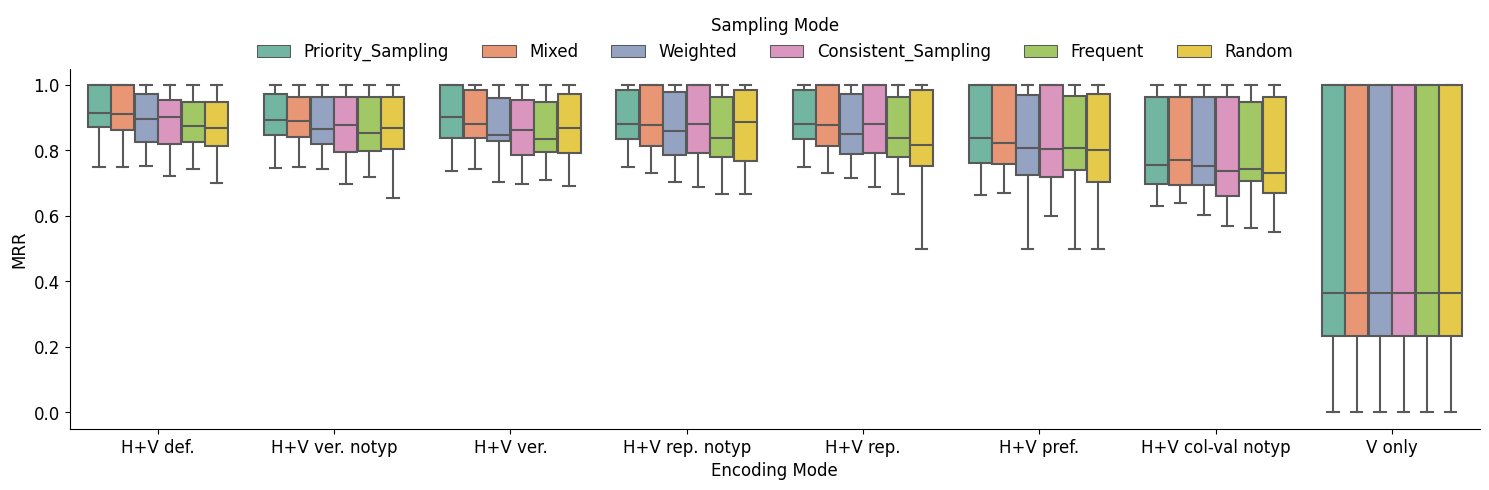

     encoding_mode      sampling_mode  sampling_size      mean    median       min  max       std
18        H+V def.  Priority_Sampling             10  0.915940  0.914493  0.750135  1.0  0.071059
16        H+V def.              Mixed             10  0.913547  0.912008  0.750000  1.0  0.072918
66        H+V ver.  Priority_Sampling             10  0.909283  0.903303  0.738406  1.0  0.084472
78  H+V ver. notyp  Priority_Sampling             10  0.906739  0.893139  0.746066  1.0  0.074387
64        H+V ver.              Mixed             10  0.897345  0.881944  0.744203  1.0  0.081978
54  H+V rep. notyp  Priority_Sampling             10  0.897263  0.880676  0.749758  1.0  0.083271
42        H+V rep.  Priority_Sampling             10  0.897263  0.880676  0.749758  1.0  0.083271
76  H+V ver. notyp              Mixed             10  0.895464  0.888889  0.750725  1.0  0.075387
77  H+V ver. notyp              Mixed             30  0.894033  0.897917  0.716667  1.0  0.077247
22        H+V def.  

,encoding_mode,sampling_mode,sampling_size,mean,median,min,max,std
18,H+V def.,Priority_Sampling,10,0.915940,0.914493,0.750135,1.0,0.071059
16,H+V def.,Mixed,10,0.913547,0.912008,0.750000,1.0,0.072918
66,H+V ver.,Priority_Sampling,10,0.909283,0.903303,0.738406,1.0,0.084472
78,H+V ver. notyp,Priority_Sampling,10,0.906739,0.893139,0.746066,1.0,0.074387
64,H+V ver.,Mixed,10,0.897345,0.881944,0.744203,1.0,0.081978
...,...,...,...,...,...,...,...,...
91,V only,Priority_Sampling,30,0.513565,0.363489,0.000000,1.0,0.354596
92,V only,Random,10,0.513565,0.363489,0.000000,1.0,0.354596
93,V only,Random,30,0.513565,0.363489,0.000000,1.0,0.354596
94,V only,Weighted,10,0.513565,0.363489,0.000000,1.0,0.354596


In [283]:
df = 'server_results/grid_search_temp/valentine_ChEMBL_grid_search_results_20241121143622.csv'
df = pd.read_csv(df)
df = handle_matcher_names(df)
plot_grouped_bar(df, 'encoding_mode', 'sampling_mode','sampling_size', 'mrr', 'ChemBL')
# plot_grouped_bar(df, 'encoding_mode', 'sampling_mode','sampling_size', 'All_RecallAtSizeofGroundTruth', 'ChemBL')



best_aggregate(df)

OpenData


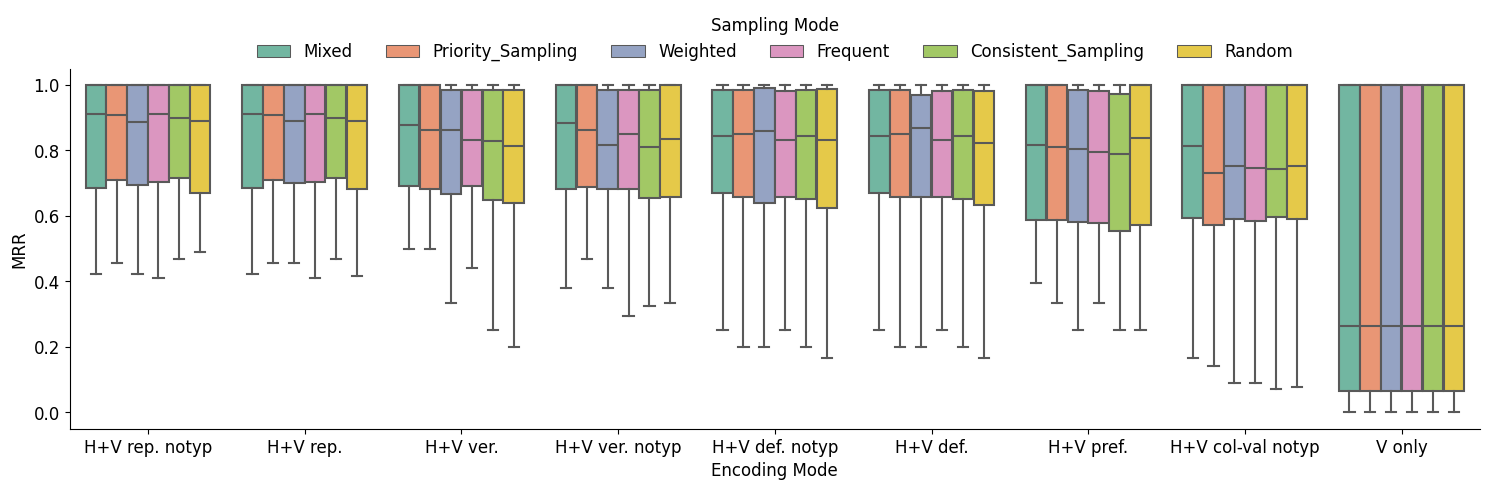

     encoding_mode        sampling_mode  sampling_size      mean    median       min  max       std
69  H+V rep. notyp               Random             30  0.862371  0.927778  0.515584  1.0  0.147196
59        H+V rep.             Weighted             30  0.848597  0.888889  0.500000  1.0  0.159438
49        H+V rep.  Consistent_Sampling             30  0.845075  0.863889  0.500000  1.0  0.158490
61  H+V rep. notyp  Consistent_Sampling             30  0.845075  0.863889  0.500000  1.0  0.158490
48        H+V rep.  Consistent_Sampling             10  0.844218  0.900000  0.468333  1.0  0.161358
60  H+V rep. notyp  Consistent_Sampling             10  0.844218  0.900000  0.468333  1.0  0.161358
54        H+V rep.    Priority_Sampling             10  0.843044  0.906667  0.457222  1.0  0.163372
66  H+V rep. notyp    Priority_Sampling             10  0.843044  0.906667  0.457222  1.0  0.163372
64  H+V rep. notyp                Mixed             10  0.836644  0.911111  0.422963  1.0  0.174614


,encoding_mode,sampling_mode,sampling_size,mean,median,min,max,std
69,H+V rep. notyp,Random,30,0.862371,0.927778,0.515584,1.0,0.147196
59,H+V rep.,Weighted,30,0.848597,0.888889,0.500000,1.0,0.159438
49,H+V rep.,Consistent_Sampling,30,0.845075,0.863889,0.500000,1.0,0.158490
61,H+V rep. notyp,Consistent_Sampling,30,0.845075,0.863889,0.500000,1.0,0.158490
48,H+V rep.,Consistent_Sampling,10,0.844218,0.900000,0.468333,1.0,0.161358
...,...,...,...,...,...,...,...,...
100,V only,Mixed,10,0.481931,0.263651,0.000000,1.0,0.433982
99,V only,Frequent,30,0.481931,0.263651,0.000000,1.0,0.433982
98,V only,Frequent,10,0.481931,0.263651,0.000000,1.0,0.433982
96,V only,Consistent_Sampling,10,0.481931,0.263651,0.000000,1.0,0.433982


In [ ]:
file ='valentine_OpenData_grid_search_results_20241121161257.csv'
file = 'server_results/grid_search_temp/'+file

df = pd.read_csv(file)
df = handle_matcher_names(df)
# plot_grouped_bar(df, 'encoding_mode', 'sampling_mode','sampling_size', 'mrr', 'OpenData')
plot_grouped_bar(df, 'encoding_mode', 'sampling_mode','sampling_size', 'All_RecallAtSizeofGroundTruth', 'OpenData')



best_aggregate(df)

gdc


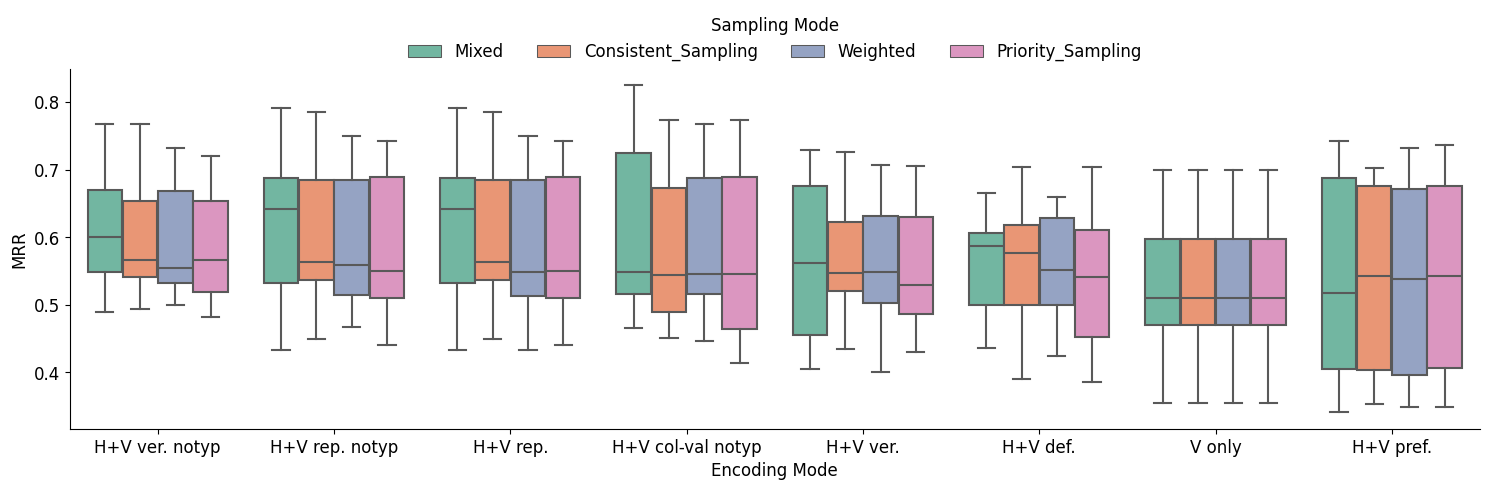

In [285]:
df = 'server_results/grid_search_temp/gdc_studies_gdc_studies_grid_search_results_20241121141757.csv'
df = pd.read_csv(df)
df = handle_matcher_names(df)
plot_grouped_bar(df, 'encoding_mode', 'sampling_mode','sampling_size', 'mrr', 'gdc')